In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')
import os
train = pd.read_csv("train.csv", parse_dates=["datetime"])
test = pd.read_csv("test.csv", parse_dates=["datetime"])

In [4]:
print(train.shape)
print(train.columns)

(10886, 12)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


In [5]:
print(test.shape)
print(test.columns)

(6493, 9)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [6]:
del train['casual']
del train['registered']

In [8]:
print('===== train =====')
print(train.isnull().sum())
print('===== test =====')
print(test.isnull().sum())

===== train =====
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64
===== test =====
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [11]:
for val in ['season', 'holiday', 'workingday','weather']:
    train[val] = train[val].astype('category')
    test[val] = test[val].astype('category')

In [12]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

In [13]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

Text(20, 0.0065, 'kurtosisness: 1.299')

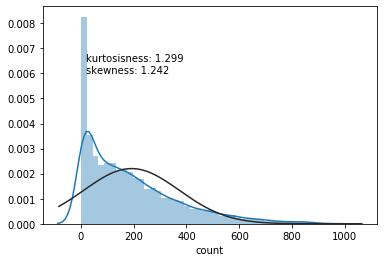

In [14]:
target = train['count']
sns.distplot(target, fit = norm)
plt.annotate('skewness: {0}'. format(np.round(skew(target),3)), xy=(20,0.006))
plt.annotate('kurtosisness: {0}'.format(np.round(kurtosis(target),3)),xy = (20,0.0065))

mean : 1.4479099120802691e-15
std  : 1.0


Text(2, 1, 'kurtosisness: 1.299')

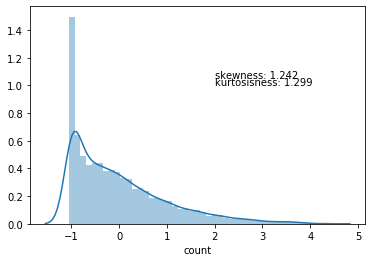

In [15]:
def scaler(x):
    return ( x - np.mean(x)) / np.std(x)

sns.distplot(scaler(target))
print('mean :',np.mean(scaler(target)))
print('std  :',np.std(scaler(target)))
plt.annotate('skewness: {0}'. format(np.round(skew(scaler(target)),3)),
             xy =(2,1.05))
plt.annotate('kurtosisness: {0}'. format(np.round(kurtosis(scaler(target)),3)),
             xy =(2,1))

Text(1, 0.32, 'kurtosisness: -0.12')

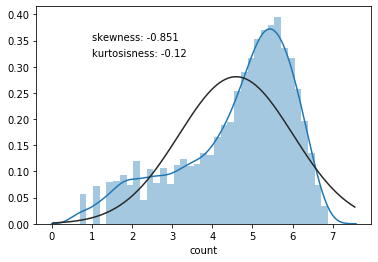

In [16]:
sns.distplot(np.log1p(target), fit = norm)

plt.annotate('skewness: {0}'.format(np.round(skew(np.log1p(target)),3)), xy = (1,0.35))
plt.annotate('kurtosisness: {0}'.format(np.round(kurtosis(np.log1p(target)),3)), xy = (1,0.32))

In [17]:
train['count']  = np.log1p(target)

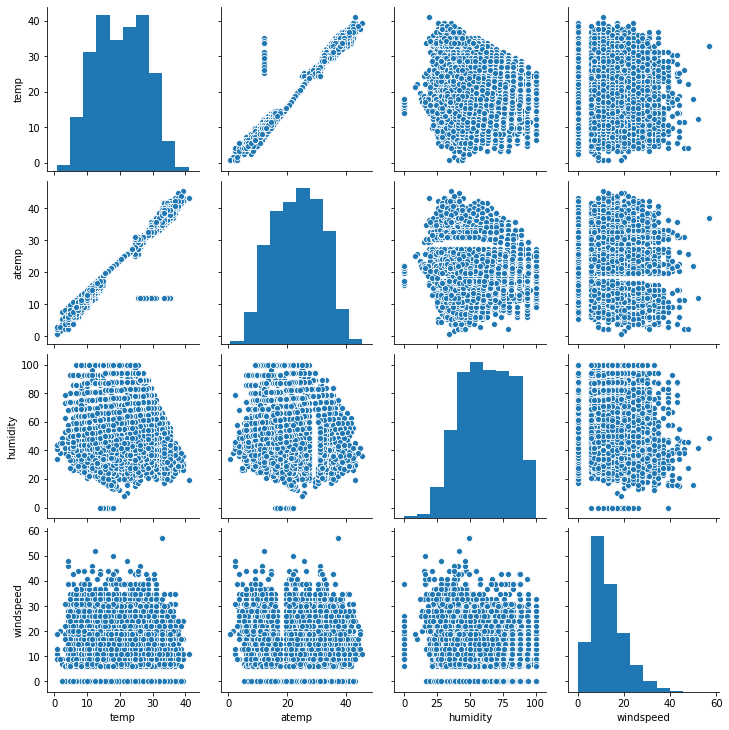

In [18]:
sns.pairplot(train[['temp','atemp','humidity', 'windspeed']])

In [19]:
train[['temp','atemp','count']].corr(method='pearson')

,temp,atemp,count
temp,1.000000,0.984948,0.376587
atemp,0.984948,1.000000,0.372167
count,0.376587,0.372167,1.000000


In [20]:
del train['atemp']
del test['atemp']

In [21]:
for val in ['windspeed','humidity','temp']:
    print ('{}` skewness : {:.3f}'.format(val, skew(train[val])))

windspeed` skewness : 0.589
humidity` skewness : -0.086
temp` skewness : 0.004


In [23]:
for i in [0,1,2,3,4] :
    
    train['hour'].replace(i, i+24, inplace = True)
    test['hour'].replace(i, i+24, inplace = True)
    
train.hour.value_counts()

23    456
18    456
16    456
22    456
14    456
21    456
13    456
17    456
20    456
12    456
15    456
19    456
24    455
9     455
10    455
8     455
11    455
6     455
7     455
25    454
5     452
26    448
28    442
27    433
Name: hour, dtype: int64

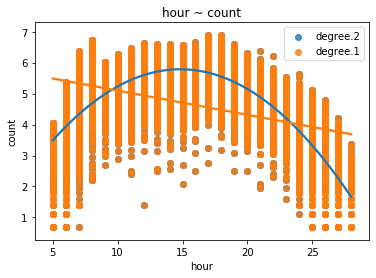

In [24]:
plt.scatter(x= train['hour'],
           y = train['count'],
           alpha = 0.3,
           color = 'blue')

plt.xlabel('hour')
plt.ylabel('count')

plt.title('hour ~ count')

sns.regplot(x = train['hour'],
            y = train['count'],
           order = 2 , label = 'degree.2')
sns.regplot(x = train['hour'],
            y = train['count'],
           order = 1 , label = 'degree.1')

plt.legend(loc = 'upper right')
plt.show()

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

lr_m = LinearRegression()
poly_m = LinearRegression()
rfc = RandomForestClassifier()

train_hour = train.loc[:, 'hour'].values
test_hour = test.loc[:, 'hour'].values


train_hour = train_hour.reshape(-1, 1)
test_hour = test_hour.reshape(-1, 1)

poly = PolynomialFeatures(degree=2)

train_hour_sqr = poly.fit_transform(train_hour)
test_hour_sqr = poly.fit_transform(test_hour)

lr_m.fit(train_hour, target)
poly_m.fit(train_hour_sqr, target)

pred_lr = lr_m.predict(train_hour)
pred_poly = poly_m.predict(train_hour_sqr)

lr_score = mean_squared_error(target, pred_lr)
poly_score = mean_squared_error(target, pred_poly)

r2_lr = r2_score(target, pred_lr)
r2_poly = r2_score(target, pred_poly)

print('r2_score (degree = 1) : {0:.3f} \n  MSE : {1:.3f}'
      .format(r2_lr, lr_score))
print('======================================================')
print('r2_score(degree = 2) : {0:.3f} \n MSE : {1:.3f}'
      .format(r2_poly, poly_score))
print('======================================================')
print('polynomial regression estimators : ({1:.3f}) * hour^2 + ({0:.3f}) * hour + ({2:.3f})'
      .format(poly_m.coef_[1],poly_m.coef_[2], poly_m.intercept_))

r2_score (degree = 1) : 0.062 
  MSE : 30770.360
r2_score(degree = 2) : 0.347 
 MSE : 21438.386
polynomial regression estimators : (-2.268) * hour^2 + (68.167) * hour + (-208.119)


In [26]:
train['hour_sqr'] = np.square(train['hour'])
test['hour_sqr'] = np.square(test['hour'])

In [27]:
train.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [28]:
train.loc[train.dayofweek >= 5,'holiday'] = 1
test.loc[test.dayofweek >= 5, 'holiday'] = 1

In [29]:
train.holiday.value_counts()

0    7412
1    3474
Name: holiday, dtype: int64

In [30]:
del train['datetime']
del test['datetime']

In [31]:
def rmsle(y, pred):
    log_y=np.log1p(y+1)
    log_pred=np.log1p(pred + 1)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

rmsle_score = make_scorer(rmsle)

In [32]:
target = train['count']
train.drop('count', axis = 1, inplace = True) # target, feature 분리

In [33]:
rf_reg = RandomForestRegressor(n_estimators=1000, n_jobs = -1,
                               random_state = 777)
# 1000개의 의사결정 나무 생성, cpu 집중, 난수 고정

x_train, x_test, y_train, y_test = train_test_split(train,
                                                    target,
                                                    test_size = 0.3,
                                                    random_state = 777)

rf_reg.fit(x_train, y_train)

pred = rf_reg.predict(x_test)

pred = np.expm1(pred)
y_test = np.expm1(y_test)

print('RandomForest score : ', rmsle(pred, y_test))

RandomForest score :  0.29986122091463835


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

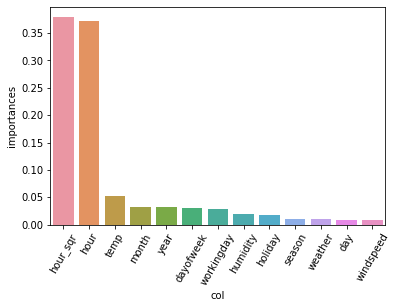

In [34]:
feat_imp = {'col' : train.columns,
            'importances' : rf_reg.feature_importances_}

feat_imp = pd.DataFrame(feat_imp).sort_values(by = 'importances', ascending = False)

sns.barplot(x = feat_imp['col'] ,
            y = feat_imp['importances'])
plt.xticks(rotation =  60)

In [35]:
print(feat_imp)

           col  importances
12    hour_sqr     0.378642
10        hour     0.371392
4         temp     0.052700
8        month     0.032788
7         year     0.031704
11   dayofweek     0.030383
2   workingday     0.028677
5     humidity     0.020132
1      holiday     0.017098
0       season     0.010931
3      weather     0.009347
9          day     0.008142
6    windspeed     0.008064
